Note: Running the entire notebook may take several hours.

# Music Recommender System   
Team 5 - Bai and Mehroze


We plan to build a song recommendation system using the Million Song Dataset similar to what
companies like Pandora, Spotify etc. use to build personalized playlists and recommend songs to
users. Recommendation system have immense business value as they improve user experience by
allowing users to discover new relevant music, build their own streaming channels etc. leading them
to consume more music and driving up company’s revenue. 


In this notebook, we explored three types of recommendation models: 
1. Popularity-based model
2. Item-based Collaborative Filtering
2. Latent Factor model (Singular Value Decomposition)



# Motivation

The motivation to work on a recommendation system came from lectures in class and our general
curiosity about the topic. It is something that neither of us has worked on previously but have always
wanted to. Working on a music dataset is also something that interested both of us. We found a
comprehensive database of songs that includes information about both the user consumption of
music and song attributes. Music recommendation systems are something both of us interact with on
a daily basis so it would be interesting to learn how to implement it ourselves. One blogpost that we
found particularly interesting on the topic was a comprehensive overview of the recommendation
algorithm behind Spotify’s Discover Weekly feature that uses multiple machine learning approaches
to recommend users a personalized playlist on a weekly basis. [Spotify Discover Weekly - https://medium.com/s/story/spotifys-discover-weekly-how-machine-learning-findsyour-new-music-19a41ab76efe

# Dataset 


The Million Song Dataset is a freely-available collection of audio features and metadata for a million
contemporary popular music tracks. The Million Song Dataset Challenge is a joint effort between the
Computer Audition Lab at UC San Diego and LabROSA at Columbia University. The user data for
the challenge, like much of the data in the Million Song Dataset, was generously donated by The
Echo Nest, with additional data contributed by SecondHandSongs, musiXmatch, and Last.fm2
. The
core of the dataset is the feature analysis and metadata for one million songs. The dataset does not
include any audio, only the derived features. 


We use the "Taste profile subset" dataset that is auxillary to the popular million songs dataset available at: [The Million Song Dataset](https://labrosa.ee.columbia.edu/millionsong/)
The dataset consists of metadata for a million contemporary popular music tracks. The entire dataset is of 280 GB, and we deal with only 3 GB of sample data based on the underlying distribution of the data, which still requires a lot of computational capacity and memory.

In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt;
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### 1. Import Data from log files and basic exploration 
Since, the overall dataset has more than a million unique users and records about 384,000 songs, we would work with a subset (10000 records) of data

In [4]:
dfsongs = pd.read_csv("train_triplets.txt", sep="\t", nrows=10000, names=['user', 'song', 'play_count'], header=None)

Let us inspect some of the imported records and other characteristics of data before we proceed further

In [5]:
dfsongs.head(5)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


### The Pareto Principle
Acoording to the pareto principle, typically only a few number of users consume a majority of the services while most other users use the services very rarely. We are interested to see whether this phenomenon exists in our data by grouping the records by user id.

### 2. Summarizing records by users and songs:

We first summarize the records by users and then by songs.    
<strong>2.1 Users - play count summary </strong>

In [20]:
from collections import defaultdict
usersDict = defaultdict(int)
with open("train_triplets.txt", "r") as songFile:
    for record in songFile:
        #Fetch user id as the first item from a tab delimited line of record
        user = record.split("\t")[0]
        #Fetch song play count as the last item from a tab delimited line of record
        play_count = int(record.split("\t")[2])
        #Update song play count for a user
        usersDict[user] += play_count
        
userPlayCountList = [{'user': u, 'play_count': p} for u,p in usersDict.items()]
dfSongsPlayCount = pd.DataFrame(userPlayCountList)
#Arrange the user songs played records in descending order to facilitate further analysis
dfSongsPlayCount = dfSongsPlayCount.sort_values(by = 'play_count', ascending = False)
dfSongsPlayCount.to_csv("songs_play_count.csv", index=None)

As seen earlier, now we arbitrarily consider top 40% of the songs play count and need to determine the number of users accounting for this percentage. So, we consider only top 100,000 users ranked according to number of songs listened by them.

In [21]:
totalPlayCount = sum(dfSongsPlayCount.play_count)
(float(dfSongsPlayCount.head(n=100000).play_count.sum())/totalPlayCount)*100
dfUserSubset = dfSongsPlayCount.head(n=100000)

<strong>2.2 Songs - play count summary:</strong>

In [22]:
songsDict = defaultdict(int)
with open("train_triplets.txt", "r") as songFile:
    for record in songFile:
        #Fetch song id as the first item from a tab delimited line of record
        song = record.split("\t")[1]
        #Fetch song play count as the last item from a tab delimited line of record
        play_count = int(record.split("\t")[2])
        #Update song play count for a song
        songsDict[song] += play_count
        
songPlayCountList = [{'song': s, 'play_count': p} for s,p in songsDict.items()]
dfSongsPlaySummary = pd.DataFrame(songPlayCountList)
#Arrange the user songs played records in descending order to facilitate further analysis
dfSongsPlaySummary = dfSongsPlaySummary.sort_values(by = 'play_count', ascending = False)
dfSongsPlaySummary.to_csv("songs_summary.csv", index=None)

In [23]:
(float(dfSongsPlaySummary.head(n=30000).play_count.sum())/totalPlayCount)*100

78.39315366645269

#### Observation:
We observe that only top 30% of the songs are listened on almost 80% of the occassions and less than 40% of the users listen to almost all the songs.   
So, we subset the songs and users summary datasets accordingly.   

In [24]:
dfSongPlayCountSubset = dfSongsPlaySummary.head(n=30000)

Now, we have obtained top 30% of the popular songs that users listen. Next, we need to identify these songs from the original dataset that contained play counts corresponding to each user for these songs.

In [25]:
dfAllSongs = pd.read_csv("train_triplets.txt", sep="\t", names=['user', 'song', 'play_count'], header=None)
#Filter records for top 40% users using the users subset found earlier
dfSongsTopUsers = dfAllSongs[dfAllSongs.user.isin(list(dfUserSubset.user))]
dfSongsTopSongs = dfSongsTopUsers[dfSongsTopUsers.song.isin(list(dfSongPlayCountSubset.song))]

In [26]:
#Save the top 30 songs dataset to a file
dfSongsTopSongs.to_csv("top_Songs_Subset.csv", index=False)
#Find the number of records in this subset
dfSongsTopSongs.shape

(10774558, 3)

So, we have obtained about 1 Million records related to top 30% of the popular songs. We also delete the unwanted subset dataframes to free up the memory

In [27]:
del dfAllSongs
del dfSongsTopUsers

Looking at the few records from the newly obtained subset of popular songs

In [28]:
dfSongsTopSongs.head(5)

,user,song,play_count
498,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12
499,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1
500,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1
501,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1
502,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7


### 3. Enhance Dataset with Song Track Details
Though we have obtained a subset of popular songs, it lacks song titles, artist names and other such details. These details can be retrived from a available supporting dataset of metadata in SQLite format at [Million Songs Metdata](https://labrosa.ee.columbia.edu/millionsong/pages/getting-dataset#subset)

In [30]:
conn = sqlite3.connect('track_metadata1.db')
cur = conn.cursor()
#Find the name of tables in the database
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall()

[('songs',)]

In [32]:
#Retrieve details of song tracks from the metadata file
dfTrackMetadata = pd.read_sql(con=conn, sql='select * from songs')
dfTrackMetadata_sub = dfTrackMetadata[dfTrackMetadata.song_id.isin(list(dfSongPlayCountSubset.song))]

Observe the song details dataset

In [33]:
dfTrackMetadata_sub.head(3)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
115,TRMMGCB128E079651D,Get Along (Feat: Pace Won) (Instrumental),SOHNWIM12A67ADF7D9,Charango,ARU3C671187FB3F71B,067102ea-9519-4622-9077-57ca4164cfbb,Morcheeba,227.47383,0.819087,0.533117,2002,185967,-1,0
123,TRMMGTX128F92FB4D9,Viejo,SOECFIW12A8C144546,Caraluna,ARPAAPH1187FB3601B,f69d655c-ffd6-4bee-8c2a-3086b2be2fc6,Bacilos,307.51302,0.595554,0.400705,0,6825058,-1,0
145,TRMMGDP128F933E59A,I Say A Little Prayer,SOGWEOB12AB018A4D0,The Legendary Hi Records Albums_ Volume 3: Ful...,ARNNRN31187B9AE7B7,fb7272ba-f130-4f0a-934d-6eeea4c18c9a,Al Green,133.58975,0.779490,0.599210,1978,5211723,-1,11898


### 4. Preprocessing the data 
Now that we have all the relevant information, we need to aggregate the song details and user Ids and remove the unwanted columns from the final cleaned table

In [34]:
del(dfTrackMetadata_sub['track_id'])
del(dfTrackMetadata_sub['artist_mbid'])
#Drop duplicate songs ids, as we are concerned with only unique songs
dfTrackMetadata_sub.drop_duplicates(['song_id'], inplace=True)
#Join the earlier obtained top popular songs dataset and this metadata dataframe on song id
dfPopularSongMetaDataMerged = pd.merge(dfSongsTopSongs, dfTrackMetadata_sub, how="left", 
                                      left_on="song", right_on = "song_id")
#Keep only relevant columns
dfPopularSongMetaDataMerged = dfPopularSongMetaDataMerged[['user', 'song', 'title',
                                                           'play_count', 'release', 'artist_name', 'year']]
dfPopularSongMetaDataMerged.head(3)

C:\Users\mehro\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,user,song,title,play_count,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,You And Me Jesus,12,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,Harder Better Faster Stronger,1,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,Uprising,1,Uprising,Muse,0


In [35]:
#saving the final dataset that we will be working on
df_recsys.to_csv('final_song_data.csv')

In [21]:
# split data into train and test
#train_data, test_data = train_test_split(dfPopularSongMetaDataMerged, test_size = 0.20, random_state=0)
#print(train_data.head(5))

                                              user                song  \
1424977   8946a35ad8622f1e63cfa8d4e47e0bec2708a790  SOJUKAU12AB018CB15   
6288351   5da0b83c67f386f2c2b64e08356d4d2a6f7e9959  SOENUIS12A6D4F8A13   
1087461   0ecd0f806a076b2bea4768bcbf77581396438d4f  SOONUJT12A6D4F64EA   
1520076   42b3f8b7a57f3c2e27b877bf9b82c58f3525a28d  SOYEHBG12A8C13C4F7   
10433056  d972d65afcdbdaca3a665f7cf0d430a8fab3afb5  SOXESAC12A8C13357F   

                                              title  play_count  \
1424977                                    She Said           5   
6288351                Possession (Unreleased 2000)           1   
1087461                      Working In A Coal Mine           1   
1520076                                You Found Me           5   
10433056  Number Five With A Bullet (Album Version)           1   

                                         release         artist_name  year  
1424977       The Defamation of Strickland Banks              Plan B     0 

### 5. Recommendation Systems 

### 5.1. Popularity based recommendation:    
This is a basic type of recommendation offered to users. It relies on the simple logic that if some content is highly popular among users, that content is a natural candidate to be introduced to other users.    
Thus, we build a recommender that suggests users to listen to most popular songs that they haven't yet heard. It does not take into account user's taste or listening history.

In [36]:
def create_popularity_recommendation(songData, user, song):
    #Get a count of users for each unique song as recommendation score
    songDataGrouped = songData.groupby([song]).agg({user: 'count'}).reset_index()
    songDataGrouped.rename(columns = {user: 'score'},inplace=True)
    
    #Sort the songs based upon recommendation score
    songDataSorted = songDataGrouped.sort_values(['score', song], ascending = [0,1])
    
    #Generate a recommendation rank based upon score
    songDataSorted['Rank'] = songDataSorted['score'].rank(ascending=0, method='first')
        
    #Get the top 10 recommendations
    popularityBasedRecommendations = songDataSorted.head(10)
    return popularityBasedRecommendations

The top 10 popularity based recommendations for songs are:

In [37]:
recommendations = create_popularity_recommendation(dfPopularSongMetaDataMerged,'user','title')
recommendations

,title,score,Rank
19580,Sehr kosmisch,18626,1.0
5780,Dog Days Are Over (Radio Edit),17635,2.0
27314,You're The One,16085,3.0
19542,Secrets,15138,4.0
18636,Revelry,14945,5.0
25070,Undo,14687,6.0
7530,Fireflies,13085,7.0
9640,Hey_ Soul Sister,12993,8.0
25216,Use Somebody,12793,9.0
9921,Horn Concerto No. 4 in E flat K495: II. Romanc...,12346,10.0


### 5.2 Item-Based Collaborative Filtering

Item-based filtering approach involves defining a co-occurrence matrix based on a song a user likes. We are seeking to answer a question, for each song, what a number of time a user, who have listened to that song, will also listen to another set of other songs. To further simplify this, based on what a user likes in the past, what other similar songs will the user like based on what other similar users have liked.

In [52]:
#For the lack of computational power, the dataset used for item-based collaborative filtering is 
#the original 10k songs dataset rather than the one processed one (it takes several hours to run)

triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

song_df_1 = pd.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_df_2 =  pd.read_csv(songs_metadata_file)

#Merge the two dataframes above to create input dataframe for recommender systems
song_df = pd.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left") 
song_df = song_df.head(10000)

#adding another column called song
song_df['song'] = song_df['title'].map(str) + " - " + song_df['artist_name']

In [40]:
#this dataset takes several hours to run. For the purpose of collaborative filtering, it is ignored 
#preparing the dataset for item based collaborative filtering

# song_df = dfPopularSongMetaDataMerged
# song_df.columns = ['user_id', 'song_id', 'title','play_count', 'release', 'artist_name', 'year']


In [54]:
#getting unique users in the dataset
users = song_df['user_id'].unique()

In [55]:
#splitting the dataset into train and test
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)
print(train_data.head(5))

                                       user_id             song_id  \
7389  94d5bdc37683950e90c56c9b32721edb5d347600  SOXNZOW12AB017F756   
9275  1012ecfd277b96487ed8357d02fa8326b13696a5  SOXHYVQ12AB0187949   
2995  15415fa2745b344bce958967c346f2a89f792f63  SOOSZAZ12A6D4FADF8   
5316  ffadf9297a99945c0513cd87939d91d8b602936b  SOWDJEJ12A8C1339FE   
356   5a905f000fc1ff3df7ca807d57edb608863db05d  SOAMPRJ12A8AE45F38   

      listen_count                 title  \
7389             2      Half Of My Heart   
9275             1  The Beautiful People   
2995             1     Sanctify Yourself   
5316             4     Heart Cooks Brain   
356             20                 Rorol   

                                                release      artist_name  \
7389                                     Battle Studies       John Mayer   
9275             Antichrist Superstar (Ecopac Explicit)   Marilyn Manson   
2995                             Glittering Prize 81/92     Simple Minds   
5316  Ever

#### Pick the user id for which you need song recommendations

In [62]:
#getting songs user 20 listens to
user_id = users[34]
user_data = train_data[train_data['user_id'] == user_id]
user_songs = list(user_data['song'].unique())
user_items_df = pd.DataFrame(user_songs)
user_items_df.columns = ['User Songs']
print("Training data songs for the user with User ID: " + user_id)

#printing thr playlist of user 20
user_items_df

Training data songs for the user with User ID: 3f152d355d53865a2ca27ac5ceeffb7ebaea0a26


,User Songs
0,Prego Amore - Erlend Øye
1,Para Tu Amor - Juanes
2,Whatcha Say - Jason Derulo
3,Sing_ Sing_ Sing (Key-E-Premiere Performance P...
4,Rayando el sol - Maná
5,Dress Me Like a Clown - Margot & The Nuclear S...
6,Only You-Bad Boy Remix (Featuring The Notoriou...
7,Amame - Juanes
8,Gotas De Agua Dulce - Juanes
9,La Camisa Negra - Juanes


In [63]:
#checking the number of unique songs in the user's playlist and in the training dataset
all_songs = list(train_data['song'].unique())
print("No. of unique songs for the user: %d" % len(user_songs))
print("no. of unique songs in the training set: %d" % len(all_songs))

No. of unique songs for the user: 53
no. of unique songs in the training set: 4483


#### Constructing the co-occurrence matrix

In [64]:
#Get unique users for a particular song
def list_song_listeners(song):
    song_listeners = ()
    song_data = train_data[train_data['song'] == song]
    song_listeners = set(song_data['user_id'].unique())

    return song_listeners

In [65]:
#Get users for all the songs that are in the user_songs list
user_songs_users = []        
for i in range(len(user_songs)):   
    user_songs_users.append(list_song_listeners(user_songs[i]))

#initialize the co-occurrence matrix with the size equal to: length of user's playlist x length of all the songs in the train data
co_occ_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)


#calculating similarity between each song a user listens to and all the other unique songs present in the train dataset

for i in range(len(all_songs)):
    
    #Get unique listeners of song i from the all_songs list
    
    songs_i_data = train_data[train_data['song'] == all_songs[i]]
    users_i = set(songs_i_data['user_id'].unique())
    
    for j in range(len(user_songs)):       
        
        #Get unique listeners of song j from the all_songs list
        
        users_j = user_songs_users[j]

        #Calculate common listeners of songs i and j
        common_users = users_i.intersection(users_j)

        #Calculate cooccurence_matrix[i,j] as Jaccard Index if there are common listeners of the two songs i and j
        if len(common_users) != 0:
            
            #Calculate union of listeners of songs i and j
            users_union = users_i.union(users_j)

            co_occ_matrix[j,i] = float(len(common_users))/float(len(users_union))
        
        #if no common users then Jaccard similarity is zero
        else:
            co_occ_matrix[j,i] = 0

#### Using the co-occurrence matrix to get top-10 song recommendations

In [67]:
print("Non-zero values in cooccurence_matrix are: ", np.count_nonzero(co_occ_matrix))
        
#Calculating a weighted average of the values in the co-occurrence matrix for all user songs
user_similarity_scores = co_occ_matrix.sum(axis=0)/float(co_occ_matrix.shape[0])
user_similarity_scores = np.array(user_similarity_scores)[0].tolist()

#Sorting the scores based on their values to get top recommendations for the user
sort_index = sorted(((e,i) for i,e in enumerate(list(user_similarity_scores))), reverse=True)

#Creating a dataframe from to store the results in
column_names = ['user_id', 'song', 'song_score', 'song_rank']
results = pd.DataFrame(columns = column_names)

#Fill the dataframe with top 10 item based recommendations
rank = 1 
for i in range(len(sort_index)):
    
    #recommend songs that the user hasn't listened to 
    if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
        results.loc[len(results)] = [user_id, all_songs[sort_index[i][1]], sort_index[i][0], rank]
        rank = rank+1

#The corner case where there are no recommended songs for the user (cold start problem)
if results.shape[0] == 0:
    print("Because of the cold start problem with item-based recommendation, ",  
          "the suggested user has no songs for training the item similarity based recommendation model on. ",
          "Therefore, no recommendation could be provided")

results

Non-zero values in cooccurence_matrix are:  5331


,user_id,song,song_score,song_rank
0,3f152d355d53865a2ca27ac5ceeffb7ebaea0a26,Dirty Little Secret - The All-American Rejects,0.040566,1
1,3f152d355d53865a2ca27ac5ceeffb7ebaea0a26,My Humps - Black Eyed Peas,0.039308,2
2,3f152d355d53865a2ca27ac5ceeffb7ebaea0a26,When We Dance - Sting,0.037736,3
3,3f152d355d53865a2ca27ac5ceeffb7ebaea0a26,That's Just The Way We Roll - Jonas Brothers,0.037736,4
4,3f152d355d53865a2ca27ac5ceeffb7ebaea0a26,Gift From Virgo - Beyoncé,0.037736,5
5,3f152d355d53865a2ca27ac5ceeffb7ebaea0a26,En Glad Calypso Om Våren (Live '62) - Olle Ado...,0.037736,6
6,3f152d355d53865a2ca27ac5ceeffb7ebaea0a26,Le Soleil Est Près De Moi - Air,0.037736,7
7,3f152d355d53865a2ca27ac5ceeffb7ebaea0a26,Love Is Stronger Than Pride - Sade,0.037736,8
8,3f152d355d53865a2ca27ac5ceeffb7ebaea0a26,The Sweetest Taboo - Sade,0.037736,9
9,3f152d355d53865a2ca27ac5ceeffb7ebaea0a26,Hook - Blues Traveler,0.037736,10


### Song-based Recommendation System

#### Get song recommendations based on a particular song or a list of songs instead of user_id

In [68]:
#Finding songs similar to 'Yellow' by Coldplay
song_name = ['Yellow - Coldplay']

In [69]:
#Get users for all the songs that are in the user_songs list
user_songs_users = []        
for i in range(len(song_name)):   
    user_songs_users.append(list_song_listeners(song_name[i]))

#initialize the co-occurrence matrix with the size equal to: length of 'song_name' x length of all the songs in the data
co_occ_matrix = np.matrix(np.zeros(shape=(len(song_name), len(all_songs))), float)


#calculating similarity between each song a user listens to and all the other unique songs present in the train dataset

for i in range(len(all_songs)):
    
    #Get unique listeners of song i from the all_songs list
    
    songs_i_data = train_data[train_data['song'] == all_songs[i]]
    users_i = set(songs_i_data['user_id'].unique())
    
    for j in range(len(song_name)):       
        
        #Get unique listeners of song j from the all_songs list
        
        users_j = user_songs_users[j]

        #Calculate common listeners of songs i and j
        common_users = users_i.intersection(users_j)

        #Calculate cooccurence_matrix[i,j] as Jaccard Index if there are common listeners of the two songs i and j
        if len(common_users) != 0:
            
            #Calculate union of listeners of songs i and j
            users_union = users_i.union(users_j)

            co_occ_matrix[j,i] = float(len(common_users))/float(len(users_union))
        
        #if no common users then Jaccard similarity is zero
        else:
            co_occ_matrix[j,i] = 0

In [71]:
print("Non-zero values in cooccurence_matrix are: ", np.count_nonzero(co_occ_matrix))
        
#Calculating a weighted average of the values in the co-occurrence matrix for all user songs
user_similarity_scores = co_occ_matrix.sum(axis=0)/float(co_occ_matrix.shape[0])
user_similarity_scores = np.array(user_similarity_scores)[0].tolist()

#Sorting the scores based on their values to get top recommendations
sort_index = sorted(((e,i) for i,e in enumerate(list(user_similarity_scores))), reverse=True)

#Creating a dataframe from to store the results in
column_names = ['Recommended Songs', 'song_score', 'song_rank']
results = pd.DataFrame(columns = column_names)

#Fill the dataframe with top 10 item based recommendations
rank = 1 
for i in range(len(sort_index)):
    
    #recommend songs that the user hasn't listened to 
    if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in song_name and rank <= 10:
        results.loc[len(results)] = [all_songs[sort_index[i][1]], sort_index[i][0], rank]
        rank = rank+1

#The corner case where there are no recommended songs (cold start problem)
if results.shape[0] == 0:
    print("Because of the cold start problem with item-based recommendation, ",  
          "the suggested song has no similar songs for training the item similarity based recommendation model on. ",
          "Therefore, no recommendation could be provided")

results

Non-zero values in cooccurence_matrix are:  969


,Recommended Songs,song_score,song_rank
0,Fix You - Coldplay,0.375000,1
1,Creep (Explicit) - Radiohead,0.291667,2
2,Clocks - Coldplay,0.280000,3
3,Seven Nation Army - The White Stripes,0.250000,4
4,Paper Planes - M.I.A.,0.208333,5
5,Halo - Beyoncé,0.200000,6
6,The Funeral (Album Version) - Band Of Horses,0.181818,7
7,In My Place - Coldplay,0.181818,8
8,Kryptonite - 3 Doors Down,0.166667,9
9,When You Were Young - The Killers,0.166667,10


### Item-based Recommendation Model Evaluation

Precision and Recall is used to evaluate the popularity model (baseline) vs the item-based recommendation model.

Note that previous recommendation data sets such as the Netflix Prize data consisted of explicit
feedback from users, where each observation is a bounded numeric score quantifying the affinity
(positive or negative) of the user for the item in question. This motivates the use of root meansquared
error (RMSE) as a measure for model performance. However, we are working with implicit
feedback (play-counts), which is non-negative and unbounded, as well as presence/absence of a song in the recommended list, and therefore the use of RMSE as
performance measure might not be applicable. [i]
Instead, we will use a combination of precision,
recall to measure the performance of our model.

The details of the evaluation methodology are provided in the picture below.

[i]  Nolan, C. (n.d.). Co-occurrence Approach to an Item Based Recommender. Retrieved from
https://blogs.msdn.microsoft.com/carlnol/2012/06/23/co-occurrence-approach-to-an-item-based-recommender/


The evaluation metrics used are sourced from: https://github.com/dvysardana/RecommenderSystems_PyData_2016/blob/master/Evaluation.py



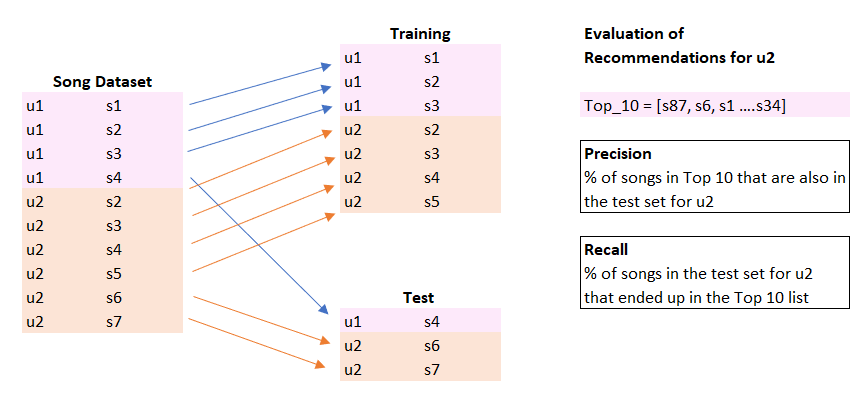

In [148]:
from IPython.display import Image
Image("Evaluation.png")

In [84]:
import Evaluation as Evaluation

start = time.time()

#percentage of users to use for precision recall calculation - the evaluation takes a long time and not all can be used
user_sample = 0.2

#Instantiate the precision_recall_calculator class imported from the Evaluation.py file
pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print("The time it took to run the evaluation process is: ", end - start, " milliseconds")

Length of user_test_and_training:330
Length of user sample:66
Getting recommendations for user:ee03697dfdf668a9cd19a44a6f257b9d6a1dc60a
No. of unique songs for the user: 27
no. of unique songs in the training set: 4501
Non zero values in cooccurence_matrix :5119
Getting recommendations for user:be0a4b64e9689c46e94b5a9a9c7910ee61aeb16f
No. of unique songs for the user: 71
no. of unique songs in the training set: 4501
Non zero values in cooccurence_matrix :11081
Getting recommendations for user:7ee2550ad5867a0793a624eb1b3284e49639c45f
No. of unique songs for the user: 7
no. of unique songs in the training set: 4501
Non zero values in cooccurence_matrix :530
Getting recommendations for user:e427f647c231c1bde8881eca5b2f5db9b3bcb2b4
No. of unique songs for the user: 11
no. of unique songs in the training set: 4501
Non zero values in cooccurence_matrix :1436
Getting recommendations for user:ca80fbb6d0deb3cae53763099e2cae7306f005ec
No. of unique songs for the user: 33
no. of unique songs in t

Non zero values in cooccurence_matrix :14122
Getting recommendations for user:523a8a39456d5a96ae8f4d5e8b8b60f3bfb31528
No. of unique songs for the user: 17
no. of unique songs in the training set: 4501
Non zero values in cooccurence_matrix :838
Getting recommendations for user:73d0a0c725c9b2c541635672bb0572bfcb7eb2b4
No. of unique songs for the user: 10
no. of unique songs in the training set: 4501
Non zero values in cooccurence_matrix :1542
Getting recommendations for user:9a0215ffab0f8322aeb36fa6636444b050462a51
No. of unique songs for the user: 11
no. of unique songs in the training set: 4501
Non zero values in cooccurence_matrix :2780
Getting recommendations for user:fe979a7b199de3ee8a78486c10e5ed13587fc359
No. of unique songs for the user: 3
no. of unique songs in the training set: 4501
Non zero values in cooccurence_matrix :497
Getting recommendations for user:179b2286bb4eea7193bcfa0c36fcfa4eade2b34d
No. of unique songs for the user: 9
no. of unique songs in the training set: 450

## Code to plot precision recall curve

Plotting precision recall curves.


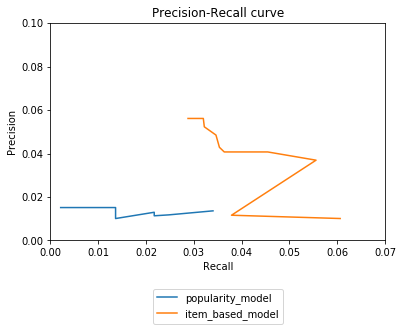

In [86]:
import pylab as pl
#plotting the precision and recall curve for popularity based and item based models
pl.clf()    
pl.plot(pm_avg_recall_list, pm_avg_precision_list, label = "Popularity Based Model")
pl.plot(ism_avg_recall_list, ism_avg_precision_list, label = "Item Based Collaborative Filtering")
pl.xlabel('Recall')
pl.ylabel('Precision')
pl.ylim([0.0, 0.9])
pl.xlim([0.0, 0.9])
pl.title('Precision-Recall Curve')
pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))


print("Plotting precision recall curves.")
pl.show()


#### Key Insight 

Item-based recommendation model has better precision and recall than the popularity based recommendation model (baseline). It means that item based recommendation has a higher percentage of songs in the user's top 10 recommended list that are also in the test list (precision) and also has a higher percentage of songs in the test list that also ended up in our model's top-10 recommended list.

Based on the context, companies can choose to balance these two metrics. Recommending a shorter list of songs may improve precision but the recall will be low. Similary, recommending a lot of songs can increase recall but may reduce precision.

#### Challenges

1- Precision and Recall in recommendation systems is highly sensitive to the number of 'relevant items'

2- Computationally expensive 

3- Fails to distinguish between an ideal recommender and worst-case recommender


### Item-Based Collaborative Filtering - Conclusion 

#### Cons
1- Cold Start Problem:
Cannot recommend songs that have previously not been listened to

2- User/Item matrix sparsity

3- Popularity bias - doesn’t play well with a long tail distribution

#### Pros
1- User and Item features are not required 

2- Minimal domain knowledge required

3- Very decent personalized recommendations




### 5.3 Latent Factor Model

We further explored the Latent Factor model, namely Single Value Decomposition (SVD) in order to capture any potential interactions between users and songs.

<strong>Pros:</strong>    
This model fully utilizes both user listening history and song metadata. It is also empirically proven to work well with large amounts of data and is currently widely adoped in the industry.

<strong>Cons:</strong>    
Due to matrix sparsity, it takes a long time and a lot of computing power to run the model. After experimenting with various model configuration, we were not able to reach global optimum before the model finished running. We included the analysis here as a proof of concept and belive that with the adoption of big data technology (running the model on Hadoop Clusters), the model will run more efficiently. 


    
<strong>Challenge: Implicit Feedback</strong></font>     
The only user feedback we have are play counts, which is unbounded. However the SVD model typically requires a bounded user feedback, for example, a rating rangeing from 1 to 5. To address this, we calculated fractional play counts by dividing the play counts per song per user by the toal play counts for all songs for the same user.   

<strong>Challenge: Matrix Sparsity and Model Run time</strong></font>  
Due to the sparsity of the matrix and the volume of the data, it takes a long time to run the svd model especially during the evaluation process. We will discuss this in more detail in the evluation section.



In [174]:
# calculate fractional play counts
dfPopularSongMetaDataMergedSum  = dfPopularSongMetaDataMerged[['user','play_count']].groupby('user').sum().reset_index()
dfPopularSongMetaDataMergedSum.rename(columns={'play_count':'total_play_count'},inplace=True)
dfPopularSongMetaDataMerged = pd.merge(dfPopularSongMetaDataMerged, dfPopularSongMetaDataMergedSum)
#Calculate the fractional play count
dfPopularSongMetaDataMerged['fractional_play_count'] = dfPopularSongMetaDataMerged['play_count']/dfPopularSongMetaDataMerged['total_play_count']

In [175]:
# take a look at the data after all the preprocessing
dfPopularSongMetaDataMerged.head()

,user,song,title,play_count,release,artist_name,year,total_play_count,fractional_play_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,You And Me Jesus,12,Tribute To Jake Hess,Jake Hess,2004,329,0.036474
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,Harder Better Faster Stronger,1,Discovery,Daft Punk,2007,329,0.003040
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,Uprising,1,Uprising,Muse,0,329,0.003040
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,Breakfast At Tiffany's,1,Home,Deep Blue Something,1993,329,0.003040
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,Lucky (Album Version),7,We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0,329,0.021277


Next, we transform the dataframe to a sparse matrix, with each row representing a user and each column representing a song.

In [176]:
from scipy.sparse import coo_matrix

small_set = dfPopularSongMetaDataMerged

#Convert user and song IDs to integer values that can be handled by numpy matices
user_codes = small_set.user.drop_duplicates().reset_index()
song_codes = small_set.song.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'}, inplace=True)
song_codes.rename(columns={'index':'song_index'}, inplace=True)
song_codes['so_index_value'] = list(song_codes.index)
user_codes['us_index_value'] = list(user_codes.index)
small_set = pd.merge(small_set,song_codes,how='left')
small_set = pd.merge(small_set,user_codes,how='left')
mat_candidate = small_set[['us_index_value','so_index_value','fractional_play_count']]
data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values

#Create a sparse matrix
data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)
data_sparse

<99996x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 10774558 stored elements in COOrdinate format>

As seen above, we have created a sparse matrix with 10,000 users and 30,000 songs. We can examine one of the records.

In [24]:
user_codes[user_codes.user =='2a2f776cbac6df64d6cb505e7e834e01684673b6']

,user_index,user,us_index_value
1669,220936,2a2f776cbac6df64d6cb505e7e834e01684673b6,1669


In [205]:
small_set.head()

,user,song,title,play_count,release,artist_name,year,total_play_count,fractional_play_count,song_index,so_index_value,user_index,us_index_value
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,You And Me Jesus,12,Tribute To Jake Hess,Jake Hess,2004,329,0.036474,0,0,0,0
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,Harder Better Faster Stronger,1,Discovery,Daft Punk,2007,329,0.003040,1,1,0,0
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,Uprising,1,Uprising,Muse,0,329,0.003040,2,2,0,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,Breakfast At Tiffany's,1,Home,Deep Blue Something,1993,329,0.003040,3,3,0,0
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,Lucky (Album Version),7,We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0,329,0.021277,4,4,0,0


In [221]:
print(small_set[small_set.user_index==0]).sort_values(by=small_set['play_count'])

                                        user                song  \
0   d6589314c0a9bcbca4fee0c93b14bc402363afea  SOADQPP12A67020C82   
1   d6589314c0a9bcbca4fee0c93b14bc402363afea  SOAFTRR12AF72A8D4D   
2   d6589314c0a9bcbca4fee0c93b14bc402363afea  SOANQFY12AB0183239   
3   d6589314c0a9bcbca4fee0c93b14bc402363afea  SOAYATB12A6701FD50   
4   d6589314c0a9bcbca4fee0c93b14bc402363afea  SOBOAFP12A8C131F36   
5   d6589314c0a9bcbca4fee0c93b14bc402363afea  SOBONKR12A58A7A7E0   
6   d6589314c0a9bcbca4fee0c93b14bc402363afea  SOBZZDU12A6310D8A3   
7   d6589314c0a9bcbca4fee0c93b14bc402363afea  SOCAHRT12A8C13A1A4   
8   d6589314c0a9bcbca4fee0c93b14bc402363afea  SODASIJ12A6D4F5D89   
9   d6589314c0a9bcbca4fee0c93b14bc402363afea  SODEAWL12AB0187032   
10  d6589314c0a9bcbca4fee0c93b14bc402363afea  SODJWHY12A8C142CCE   
11  d6589314c0a9bcbca4fee0c93b14bc402363afea  SODLLYS12A8C13A96B   
12  d6589314c0a9bcbca4fee0c93b14bc402363afea  SODLSCE12A6D4FBCAC   
13  d6589314c0a9bcbca4fee0c93b14bc402363afea  SO

AttributeError: 'NoneType' object has no attribute 'sort_values'

Now that we have our matrix ready, next step is to factorize it into 50 latent features using the svds() function from the Scipy library.

In [117]:
import importlib
import SVD_Helper

In [26]:
import SVD_Helper

K=50
utilityMatrix = data_sparse
MAX_PID = utilityMatrix.shape[1]
MAX_UID = utilityMatrix.shape[0]

U, S, Vt = SVD_Helper.compute_svd(utilityMatrix, K)

Finally, calculate the estimated matrix for few of the test users and observe the songs recommended to them by the recommender system

In [218]:
uTest = [0,3,4,5]

uTest_recommended_items = SVD_Helper.compute_estimated_matrix(utilityMatrix, U, S, Vt, uTest, K, MAX_PID, MAX_UID, True)

for  user  in  uTest:
    print("\n-------------------------------------- \
    \nRecommendation for user with id: {}\n--------------------------------------\n". format(user))
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        song_details = small_set[small_set.so_index_value == i].drop_duplicates('so_index_value')[['title','artist_name']]
        print("#{}: {} By {}".format(rank_value, list(song_details['title'])[0],list(song_details['artist_name'])[0]))
        rank_value+=1


--------------------------------------     
Recommendation for user with id: 0
--------------------------------------

#1: Song For Shelter By Fatboy Slim
#2: Like A Pen By The Knife
#3: Feel The Love By Cut Copy
#4: Around The World (Motorbass Vice Mix) By Daft Punk
#5: Calabria 2007 By ENUR Feat NATASJA
#6: Father Of Mine By Everclear
#7: One Life Stand By Hot Chip
#8: Royal Gregory By Holy Fuck
#9: Grass (2001 Digital Remaster) By XTC
#10: When Am I Going To Make A Living By Sade

--------------------------------------     
Recommendation for user with id: 3
--------------------------------------

#1: Breathe . Something/Stellar STar By Flying Lotus
#2: Valentine By Justice
#3: Let There Be Lite (Album Version) By Justice
#4: Agaetis Byrjun By Sigur Ros
#5: The Goldrush By Coldplay
#6: Not Falling Apart By Maroon 5
#7: In The Cold I'm Standing By M83
#8: Oh No! (album version) By Marina And The Diamonds
#9: Spanish Sahara By Foals
#10: The Writing On My Fathers Hand By Dead Can Da

## SVD Evaluation

By using one of Python's pre-built package (surprise), we attempted to evaluate a basic svd model with 10 latent features, learning rate = 0.05 and 5 epochs. The evaluation process took a long time to run (30 minutes) and the repoted RMSE and MAE are not good. We suspected that this is due to the sparsity of the metrics and SVD being a computationally intensive model. </br>


Since there is not an efficient way for us to fully evaluate the model results, we therefore include this model here as a proof of concept. In the future, we believe this will run more efficiently on a big data platform, for example on Hadoop clusters. 

In [177]:
import pandas as pd
from surprise import NormalPredictor
from surprise import Dataset
from surprise.model_selection import cross_validate

In [178]:
dfPopularSongMetaDataMerged.shape

(10774558, 9)

In [194]:
df = dfPopularSongMetaDataMerged[['user', 'song','fractional_play_count']]
df.rename(columns = {'user':'userID', 'song':'itemID', 'fractional_play_count':'rating'}, inplace=True)

/Users/xb/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [201]:
data = MyDataset(df, reader)

In [202]:
# create a dummy reader
reader = Reader(line_format='user item rating', rating_scale=(1, 5))

# Also, a dummy Dataset class
class MyDataset(dataset.DatasetAutoFolds):
    def __init__(self, df, reader):
        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df['userID'], df['itemID'], df['rating'])]
        self.reader=reader

data = MyDataset(df, reader)

# Run 5-fold cross-validation and print results
algo = SVD(n_factors=10, n_epochs=5, lr_all=0.05, verbose=True)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9909  0.9909  0.9909  0.9909  0.9909  0.9909  0.0000  
MAE (testset)     0.9907  0.9907  0.9907  0.9907  0.9907  0.9907  0.0000  
Fit time          64.26   85.13   81.45   83.38   81.15   79.07   7.54    
Test time         32.21   44.38   37.93   36.97   35.94   37.49   3.96    


{'test_rmse': array([0.99092465, 0.99092607, 0.99090552, 0.9909142 , 0.99090393]),
 'test_mae': array([0.9907313 , 0.99073103, 0.99070843, 0.99072055, 0.99070493]),
 'fit_time': (64.25966715812683,
  85.12712407112122,
  81.45327377319336,
  83.37923192977905,
  81.14928412437439),
 'test_time': (32.210498094558716,
  44.383127212524414,
  37.93042707443237,
  36.97197127342224,
  35.94144105911255)}

Model did not converge to global optimum. This is due to limitations in subset sample size and computing capacity. 

#### SVD 

#### Cons
1- Takes a lot of time and resources to compute

2- Fails to reach global optimum due to matrix sparsity

#### Pros
1- Utilized metadata

2- Personalized recommendation



Reference:
</br>
https://github.com/DataSorcerer/Music-Recommendation-System </br>
https://github.com/llSourcell/recommender_live/blob/master/Song%20Recommender_Python.ipynb

# Reflection and Next Steps

Taking this project further will involve creating a hybrid model of SVD and Collaborative Filtering similar to the ones used in the industry by companies like Spotify and Pandora. These hybrid models are often a linear combination of these simple collaborative filtering models along with other more complicated models averaging out the errors of all models and providing an overall better results. 

Also, processing millions of data points also necessitates the use of big data technologies like Hadoop and Spark. Spotify has one of the best recommendation systems out there and it also involves the use of Natural Language Processing to take into consideration song lyrics and other audio features which it runs of a lot of hadoop clusters. The architecture for Spotify's Discover Weekly system is found below.

Source: https://medium.com/s/story/spotifys-discover-weekly-how-machine-learning-finds-your-new-music-19a41ab76efe



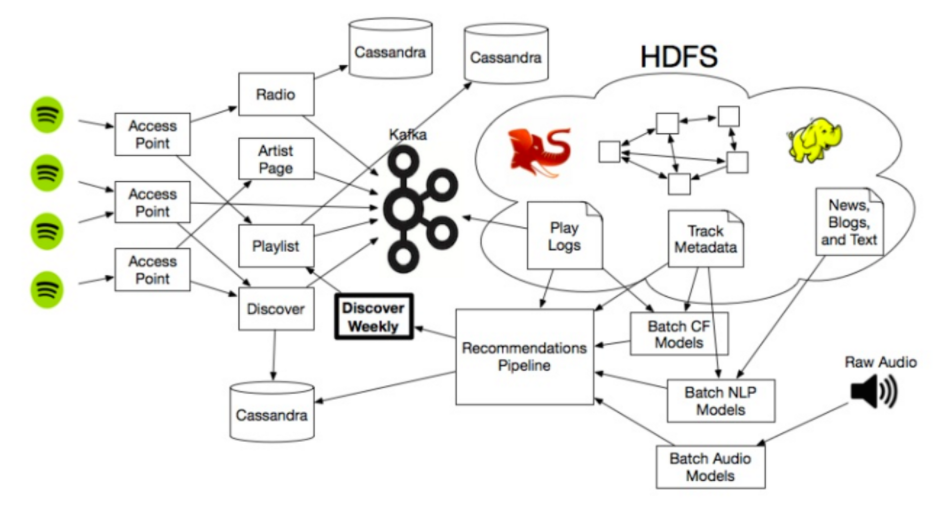

In [75]:
from IPython.display import Image
Image('spotify_architecture.png')